# Libraries 

In [73]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import time

# Visualisation
import matplotlib.pyplot as plt
import importlib.metadata
import seaborn as sns

# Image Analysis
from IPython.display import display
from PIL import Image, ImageOps
from skimage import img_as_float
from skimage.restoration import denoise_nl_means
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


# perf
from pandarallel import pandarallel

In [2]:
# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

pandas - 2.0.3
numpy - 1.24.3
seaborn - 0.12.2
PIL.Image - 9.4.0
cv2 - 4.9.0
tensorflow - 2.16.1
matplotlib -  3.7.2


# 1. Données

In [3]:
data = pd.read_csv('data2.csv')

In [4]:
display(data.head())

,uniq_id,image_path,cat1,label
0,55b85ea15a1536d46b7190ad6fff8ce7,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


In [108]:
mapping = data[['cat1', 'label']].drop_duplicates().sort_values(by='label')


display(mapping)

,cat1,label
1,Baby Care,0
43,Beauty and Personal Care,1
47,Computers,2
36,Home Decor & Festive Needs,3
0,Home Furnishing,4
37,Kitchen & Dining,5
5,Watches,6


In [109]:
list_labels = mapping['cat1'].unique()

In [5]:
display(data.groupby("label").count())

,uniq_id,image_path,cat1
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


### Création des folders

In [8]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Now 'train' and 'test' DataFrames have 'label' column equally represented
print(data_train['label'].value_counts(normalize=True))
print(data_test['label'].value_counts(normalize=True))

label
4    0.142857
2    0.142857
5    0.142857
0    0.142857
3    0.142857
1    0.142857
6    0.142857
Name: proportion, dtype: float64
label
0    0.142857
1    0.142857
4    0.142857
6    0.142857
3    0.142857
5    0.142857
2    0.142857
Name: proportion, dtype: float64


In [9]:
print('data_train shape :', data_train.shape)
print('data_test shape :', data_test.shape)

data_train shape : (840, 4)
data_test shape : (210, 4)


In [10]:
data_furnishing_train = data_train.loc[data_train['cat1']=='Home Furnishing']
data_baby_train = data_train.loc[data_train['cat1']=='Baby Care']
data_watches_train = data_train.loc[data_train['cat1']=='Watches']
data_decor_train = data_train.loc[data_train['cat1']=='Home Decor & Festive Needs']
data_kitchen_train = data_train.loc[data_train['cat1']=='Kitchen & Dining']
data_beauty_train = data_train.loc[data_train['cat1']=='Beauty and Personal Care']
data_computers_train = data_train.loc[data_train['cat1']=='Computers']

In [11]:
data_furnishing_test = data_test.loc[data_test['cat1']=='Home Furnishing']
data_baby_test = data_test.loc[data_test['cat1']=='Baby Care']
data_watches_test = data_test.loc[data_test['cat1']=='Watches']
data_decor_test = data_test.loc[data_test['cat1']=='Home Decor & Festive Needs']
data_kitchen_test = data_test.loc[data_test['cat1']=='Kitchen & Dining']
data_beauty_test = data_test.loc[data_test['cat1']=='Beauty and Personal Care']
data_computers_test = data_test.loc[data_test['cat1']=='Computers']

In [12]:
def save_images_to_folder(dataframe, base_folder, output_folder):
    # Create the base folder if it doesn't exist
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)

    # Create the specific output folder inside the base folder
    full_output_folder = os.path.join(base_folder, output_folder)
    if not os.path.exists(full_output_folder):
        os.makedirs(full_output_folder)

    # Iterate over each row in the dataframe
    for index, row in dataframe.iterrows():
        # Get the image path from the 'image_path' column
        image_path = row['image_path']

        # Extract the filename from the image path
        filename = os.path.basename(image_path)

        # Destination path for the image within the base folder
        destination_path = os.path.join(full_output_folder, filename)

        # Check if the destination file already exists
        if not os.path.exists(destination_path):
            # Copy the image file to the output folder
            shutil.copy(image_path, destination_path)
        else:
            print(f"Skipping '{filename}' as it already exists in '{full_output_folder}'")


In [13]:
save_images_to_folder(data_furnishing_train, 'data_augmentation_train', 'image_furnishing')
save_images_to_folder(data_baby_train, 'data_augmentation_train', 'image_baby')
save_images_to_folder(data_watches_train, 'data_augmentation_train', 'image_watches')
save_images_to_folder(data_decor_train, 'data_augmentation_train', 'image_decor')
save_images_to_folder(data_kitchen_train, 'data_augmentation_train', 'image_kitchen')
save_images_to_folder(data_beauty_train, 'data_augmentation_train', 'image_beauty')
save_images_to_folder(data_computers_train, 'data_augmentation_train', 'image_computers')

Skipping '5188dd28a627807407d93549580afb74.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping 'dc777afc918f513a7253187e00a11948.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping 'f41761a931135c6c043c7e04abda41b0.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping '6858fd9265d348803b18667fe43cd054.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping 'ce9207944cedeaa82e4ea6269586af2a.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping '7c785e9e26092c0b6ed038085e90d89d.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping 'a79117ea49a0533f641facdb4c99f502.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping '62e36e018c9ee4b282cf674e84054df8.jpg' as it already exists in 'data_augmentation_train\image_furnishing'
Skipping '43da6e88dcb61e027ea9112cfab158ee.jpg' as it already exists in 'data_au

Skipping '53b9357d16d4db0a1f9ec4e8ac91e743.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping 'c36ea960a14f164ee0f39ad6beb3796a.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping '8d1abb3504a19ab41e7d8b8b1d5dd839.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping 'b64149a8a9235f5199c6d8225d5dc602.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping '189fa66a5fa6f08d2802a62ecf0be298.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping 'd5d6c94b78fb0875b2894d44e7c46312.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping '19a570b6717955a8c48e5f280617ef24.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping '6f9c169adda9b562a841a9cf54b16f06.jpg' as it already exists in 'data_augmentation_train\image_watches'
Skipping '6b04c746cac2aa811d7a8753e54dc96e.jpg' as it already exists in 'data_augmentation_train\image_w

Skipping '7fd12776e6d62da6e1dd3cbc9882ee5f.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping 'ae19a81b730b48b87ca72521af8fb902.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping 'e2ae2af58ac50adf4881751ae84a9d8a.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping 'bcb8e456728013a90ba66ab3b1b783ad.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping '98659fb98a4fe903f21f5c315adbaede.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping '4f708bc74c4d29b2967dc38a1f5ae6d5.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping '0d02f4703fde00645704e15bba23e77d.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping 'fc9a650d545a50c72556bed0df59efa1.jpg' as it already exists in 'data_augmentation_train\image_computers'
Skipping 'a41371b2f8859b015031f0d5eda5184c.jpg' as it already exists in 'data_augmentati

In [14]:
save_images_to_folder(data_furnishing_test, 'data_augmentation_test', 'image_furnishing')
save_images_to_folder(data_baby_test, 'data_augmentation_test', 'image_baby')
save_images_to_folder(data_watches_test, 'data_augmentation_test', 'image_watches')
save_images_to_folder(data_decor_test, 'data_augmentation_test', 'image_decor')
save_images_to_folder(data_kitchen_test, 'data_augmentation_test', 'image_kitchen')
save_images_to_folder(data_beauty_test, 'data_augmentation_test', 'image_beauty')
save_images_to_folder(data_computers_test, 'data_augmentation_test', 'image_computers')

Skipping '597a9549a3e397d52dca62ee47b1f60a.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping '0ec47240feda42c63e42f1e9cee60f7a.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping '62a1044ba64031b9e40f98a4fb890d9d.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping '9c41f67773da27940d77460715e880be.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping 'd218c32df572e82db50faecd62179db2.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping '7ec5ac2dea80b6c5e4cfd20eba597d20.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping 'a5e1b49a1ddf038888e6de3523b475fb.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping 'a30aa3b765b613c158fd3a295ed934fa.jpg' as it already exists in 'data_augmentation_test\image_furnishing'
Skipping '9e81a24714e06b0ca9b4fed8cae42611.jpg' as it already exists in 'data_augmentati

In [15]:
path = "./data_augmentation_train/"
path_test = "./data_augmentation_test/"

# 2. FONCTIONS

In [16]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)


In [17]:
def visualisations(features):
    
    from sklearn import manifold, decomposition
    
    # Dimension reduction using PCA
    print('Shape avant PCA :', features.shape)
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(features)
    print('Shape après PCA :', feat_pca.shape)
    
    print(' ')
    print('------------------')
    print(' ')
    
    #TSNE
    temps1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, init='random', random_state=6, early_exaggeration = 20)
    X_tsne = tsne.fit_transform(feat_pca)
    duration1=time.time()-temps1
    print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")
    
    print(' ')
    print('------------------')
    print(' ')
    
    # Affichage TSNE
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = data["cat1"]

    plt.figure(figsize=(8,5))
    sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1), loc='upper left') 

    plt.show()
    
    print(' ')
    print('------------------')
    print(' ')
    
    # Agglomerative clustering
    from sklearn.cluster import AgglomerativeClustering
    cls = AgglomerativeClustering(n_clusters=7)
    cls.fit(X_tsne)
    
    # Display TSNE with predicted labels
    df_tsne["cluster"] = cls.labels_

    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="cluster",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=df_tsne,
        legend="brief")

    plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

    labels = data["label"]
    print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
    

    print(' ')
    print('------------------')
    print(' ')
    
    conf_mat = metrics.confusion_matrix(labels, cls.labels_)
    print('Confusion matrix, désordonnée :')
    print(conf_mat)
    
    print(' ')
    print('------------------')
    print(' ')
    
    cm = conf_mat
    indexes = linear_sum_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(zip(indexes[0], indexes[1]), key=lambda x: x[0])]
    cm2 = cm[:, js]
    print('Confusion matrix, ordonnée :')
    print(cm2)

    print(' ')
    print('------------------')
    print(' ')
    
    print('Matrice de confusion')
    df_cm = pd.DataFrame(cm2, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
    plt.figure(figsize = (8,5))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")


    

# 3. Classification supervisée

### Preprocess des images

In [20]:
def image_prep_fct(df) :
    prepared_images = []
    for image_num in df.index :
        img = (load_img(
            df['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    


In [21]:
images_np = image_prep_fct(data_train)
print('train : ', images_np.shape)

C:\Users\LENOVO\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


train :  (840, 224, 224, 3)


In [22]:
images_np_test = image_prep_fct(data_test)
print('test :', images_np_test.shape)

test : (210, 224, 224, 3)


In [23]:
from keras.utils import to_categorical

X = images_np
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
print(X_train.shape)

(630, 224, 224, 3)


In [117]:
print(X_val.shape)

(210, 224, 224, 3)

In [118]:
print(X_test.shape)

(210, 224, 224, 3)

## 3.1 VGG16, trained on dataset, data augmentation

In [80]:
# Data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [74]:
input_tensor = Input(shape=(224, 224, 3)) 
base_model = VGG16(weights=None, include_top=False, input_tensor=input_tensor)

In [75]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes 

In [77]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,563,847 (105.15 MB)

 Trainable params: 27,563,847 (105.15 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Train the model
batch_size = 32

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)

model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10, 
    validation_data=validation_generator,
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 247s 13s/step - accuracy: 0.1545 - loss: 11.0898 - val_accuracy: 0.1458 - val_loss: 1.9456
Epoch 2/10
 1/19 ━━━━━━━━━━━━━━━━━━━━ 3:51 13s/step - accuracy: 0.2812 - loss: 1.9423

C:\Users\LENOVO\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.2812 - loss: 1.9423 - val_accuracy: 0.1111 - val_loss: 1.9477
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 259s 14s/step - accuracy: 0.1420 - loss: 1.9457 - val_accuracy: 0.1562 - val_loss: 1.9456
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.0625 - loss: 1.9468 - val_accuracy: 0.0000e+00 - val_loss: 1.9488
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 262s 14s/step - accuracy: 0.1662 - loss: 1.9457 - val_accuracy: 0.1510 - val_loss: 1.9458
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.0312 - loss: 1.9474 - val_accuracy: 0.0556 - val_loss: 1.9491
Epoch 7/10
12/19 ━━━━━━━━━━━━━━━━━━━━ 1:42 15s/step - accuracy: 0.1217 - loss: 1.9465

KeyboardInterrupt: 

Entraînement sur le dataset = extrêmement long et très peu efficace par rapport au model pretrained

## Mobile Net

In [84]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 34,374,727 (131.13 MB)

 Trainable params: 34,340,615 (131.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


In [85]:
# Train the model
batch_size = 32

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)

model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=20, 
    validation_data=validation_generator,
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1272 - loss: 61.4980 - val_accuracy: 0.1458 - val_loss: 1.9459
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0938 - loss: 5.1840 - val_accuracy: 0.1111 - val_loss: 1.9462
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1357 - loss: 4.5638 - val_accuracy: 0.1458 - val_loss: 1.9459
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0625 - loss: 1.9555 - val_accuracy: 0.1111 - val_loss: 1.9457
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1228 - loss: 2.0022 - val_accuracy: 0.1458 - val_loss: 1.9458
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1875 - loss: 1.9466 - val_accuracy: 0.1111 - val_loss: 1.9470
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1415 - loss: 1.9585 - val_accuracy: 0.1406 - val_loss: 1.9458
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2500 - loss: 1.9445 - val_accuracy: 0.1667 - val_

In [86]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 34,374,727 (131.13 MB)

 Trainable params: 34,340,615 (131.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


In [87]:
# Train the model
batch_size = 32

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)

model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=20, 
    validation_data=validation_generator,
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2751 - loss: 23.7341 - val_accuracy: 0.1510 - val_loss: 29.8260
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3750 - loss: 4.9378 - val_accuracy: 0.1667 - val_loss: 39.0349
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4711 - loss: 2.7413 - val_accuracy: 0.1354 - val_loss: 36.8749
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5000 - loss: 1.1645 - val_accuracy: 0.2222 - val_loss: 38.4377
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5485 - loss: 1.6993 - val_accuracy: 0.2396 - val_loss: 20.6681
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7188 - loss: 1.9402 - val_accuracy: 0.1111 - val_loss: 21.2757
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6031 - loss: 1.8018 - val_accuracy: 0.1719 - val_loss: 9.8013
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7500 - loss: 0.9510 - val_accuracy: 0.2222 

Pre trained vs non pre trained : pas de débat

## 3.1 VGG16, pre-trained, no data augmentation

### Création du modèle de classification

In [18]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [19]:
print('data_train shape :', data_train.shape)
print('data_test shape :', data_test.shape)

data_train shape : (840, 4)
data_test shape : (210, 4)


In [25]:
##### Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [26]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2756 - loss: 9.5279 
Epoch 1: val_loss improved from inf to 1.10510, saving model to ./model1_best_weights.h5.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.2856 - loss: 9.2505 - val_accuracy: 0.7667 - val_loss: 1.1051
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6149 - loss: 2.1845
Epoch 2: val_loss improved from 1.10510 to 1.04019, saving model to ./model1_best_weights.h5.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 99s 10s/step - accuracy: 0.6179 - loss: 2.1715 - val_accuracy: 0.7905 - val_loss: 1.0402
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7090 - loss: 1.7469
Epoch 3: val_loss improved from 1.04019 to 0.99480, saving model to ./model1_best_weights.h5.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 185s 20s/step - accuracy: 0.7098 - loss: 1.7292 - val_accuracy: 0.7952 - val_loss: 0.9948
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7952 - loss: 0.8471
Epoch 4: val_loss improve

In [27]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.9962 - loss: 0.0139
Training Accuracy: 0.9952

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8280 - loss: 0.9727
Validation Accuracy:  0.8333


In [28]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8476
Test Accuracy       :  0.7762


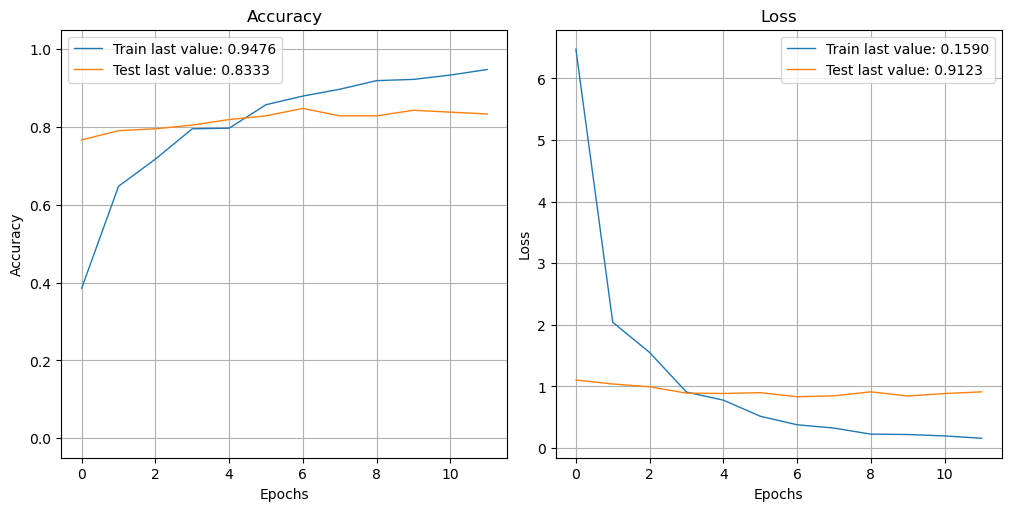

In [29]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [30]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[0 2 6 2 4 1 2 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 4 1 2 4 6 3 4 2 6 5 2
 5 6 6 0 2 2 5 2 0 1 5 0 6 5 3 3 1 5 3 5 4 3 0 4 0 6 6 4 2 0 3 1 2 5 5 5 2
 2 6 2 4 5 1 4 0 5 4 1 5 5 2 3 3 3 5 0 3 5 4 6 0 2 0 3 0 5 1 5 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 0 5 5 3 4 0 3 2 6 3 6 5 1 2 6 6 1 2 5 2 3 3 3 1 3 0 4 5 0
 5 4 0 6 0 0 0 0 2 3 1 2 4 0 5 5 4 1 5 2 4 1 0 2 1 6 4 2 4 3 4 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 2 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]


In [31]:
print("ARI : ", metrics.adjusted_rand_score(y_val_num, y_val_pred))

ARI :  0.678970008450878


In [119]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model1.predict(X_test), axis=1)
y_test_num = np.argmax(y_test, axis=1)
print(y_test_num)
print()
print(y_test_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
[0 1 4 1 1 6 0 4 3 4 3 5 2 6 5 5 4 3 3 3 2 2 0 0 6 2 5 6 1 5 3 3 4 6 0 6 2
 0 0 2 3 4 6 4 4 6 1 0 6 6 3 5 3 5 0 0 5 2 6 2 0 0 2 0 6 4 2 5 5 6 4 1 4 5
 5 0 3 1 2 1 2 5 3 6 4 0 2 0 2 4 2 1 2 1 6 2 5 3 4 3 4 2 5 3 6 1 5 3 6 1 4
 0 5 4 6 4 3 1 5 4 1 6 3 1 6 2 4 1 4 0 6 1 1 6 5 0 6 5 6 6 6 3 3 4 6 1 1 3
 1 3 4 5 5 2 1 5 6 0 4 0 3 3 2 5 3 2 6 3 0 4 1 1 5 1 5 5 0 5 2 0 2 4 4 2 4
 2 6 3 4 1 2 1 5 2 1 3 0 2 0 5 1 2 3 0 0 3 4 0 1 0]

[0 1 4 6 1 6 0 4 3 4 3 5 2 6 5 6 4 3 3 3 2 1 0 0 6 6 5 6 1 5 3 5 4 6 4 6 2
 0 0 4 3 4 6 4 0 6 1 0 6 6 3 5 3 5 3 0 5 4 6 2 0 0 2 0 6 4 2 1 5 6 4 1 4 5
 5 0 3 1 5 1 4 5 3 6 4 0 1 0 5 4 1 4 1 1 6 2 5 3 4 3 4 6 5 3 6 1 5 3 6 1 4
 4 5 4 6 4 3 1 5 1 1 6 3 1 6 2 4 1 4 0 6 1 1 6 5 4 6 5 6 6 6 5 3 0 6 1 1 3
 2 3 4 5 1 6 6 5 6 4 4 0 3 3 2 5 0 6 6 5 0 4 1 3 5 1 3 5 5 3 5 0 1 4 4 6 0
 2 6 3 4 6 5 1 5 2 3 1 4 2 5 5 1 6 3 0 3 1 4 4 1 3]


In [120]:
print("ARI : ", metrics.adjusted_rand_score(y_test_num, y_test_pred))

ARI :  0.5288998633096698


Confusion matrix, désordonnée :
[[26  0  0  1  3  0  0]
 [ 0 24  4  2  0  0  0]
 [ 0  0 27  0  1  2  0]
 [ 0  1  2 24  0  2  1]
 [ 5  0  1  3 21  0  0]
 [ 0  1  1  0  0 28  0]
 [ 0  0  1  0  0  1 28]]
 
------------------
 
Confusion matrix, ordonnée :
[[26  0  0  1  3  0  0]
 [ 0 24  4  2  0  0  0]
 [ 0  0 27  0  1  2  0]
 [ 0  1  2 24  0  2  1]
 [ 5  0  1  3 21  0  0]
 [ 0  1  1  0  0 28  0]
 [ 0  0  1  0  0  1 28]]
 
------------------
 
Matrice de confusion


<Axes: >

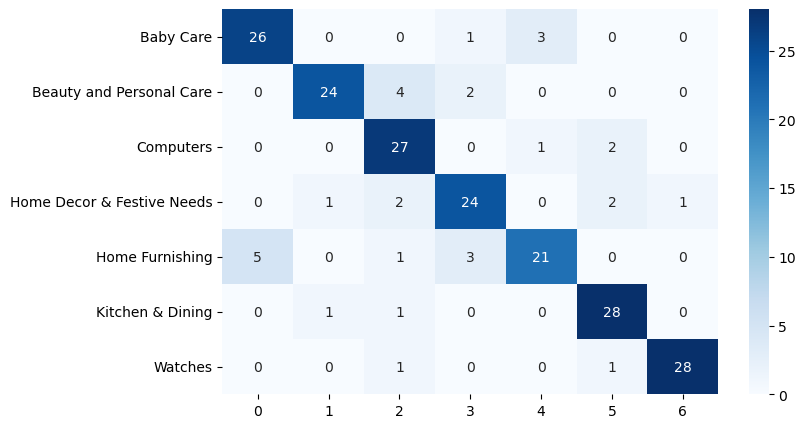

In [107]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print('Confusion matrix, désordonnée :')
print(conf_mat)
    
print(' ')
print('------------------')
print(' ')
    
cm = conf_mat
indexes = linear_sum_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(zip(indexes[0], indexes[1]), key=lambda x: x[0])]
cm2 = cm[:, js]
print('Confusion matrix, ordonnée :')
print(cm2)

print(' ')
print('------------------')
print(' ')
   
print('Matrice de confusion')
df_cm = pd.DataFrame(cm2, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")


Confusion matrix, désordonnée :
[[19  0  0  3  6  2  0]
 [ 0 23  1  2  1  0  3]
 [ 0  5 12  0  3  4  6]
 [ 1  2  0 24  0  3  0]
 [ 3  1  0  0 26  0  0]
 [ 0  2  0  2  0 25  1]
 [ 0  0  0  0  0  0 30]]
 
------------------
 
Confusion matrix, ordonnée :
[[19  0  0  3  6  2  0]
 [ 0 23  1  2  1  0  3]
 [ 0  5 12  0  3  4  6]
 [ 1  2  0 24  0  3  0]
 [ 3  1  0  0 26  0  0]
 [ 0  2  0  2  0 25  1]
 [ 0  0  0  0  0  0 30]]
 
------------------
 
Matrice de confusion


<Axes: >

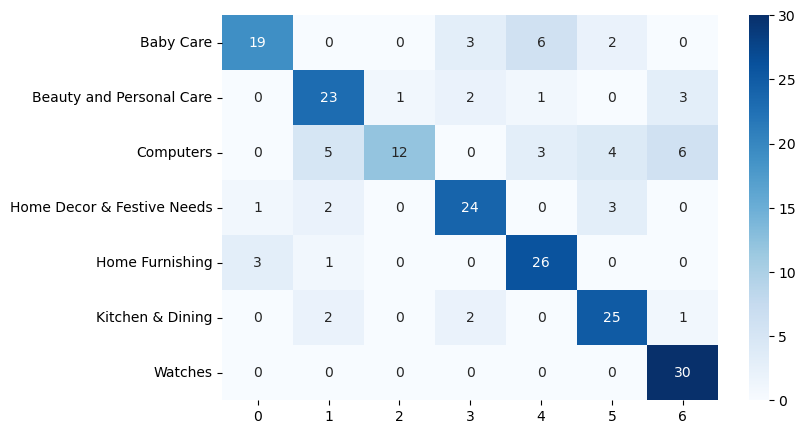

In [121]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred)
print('Confusion matrix, désordonnée :')
print(conf_mat)
    
print(' ')
print('------------------')
print(' ')
    
cm = conf_mat
indexes = linear_sum_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(zip(indexes[0], indexes[1]), key=lambda x: x[0])]
cm2 = cm[:, js]
print('Confusion matrix, ordonnée :')
print(cm2)

print(' ')
print('------------------')
print(' ')
   
print('Matrice de confusion')
df_cm = pd.DataFrame(cm2, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")


On a ici un modèle plutôt satisfaisant, notamment par rapport au VGG16 non supervisé (cf notebook de faisabilité).  
On passe d'un ARI de 0.44 à un ARI de 0.68

In [149]:
# Indices des prédictions incorrectes
incorrect_indices = np.where(y_test_num != y_test_pred)[0]

# Sample 
sample_indices = np.random.choice(incorrect_indices, size=min(9, len(incorrect_indices)), replace=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


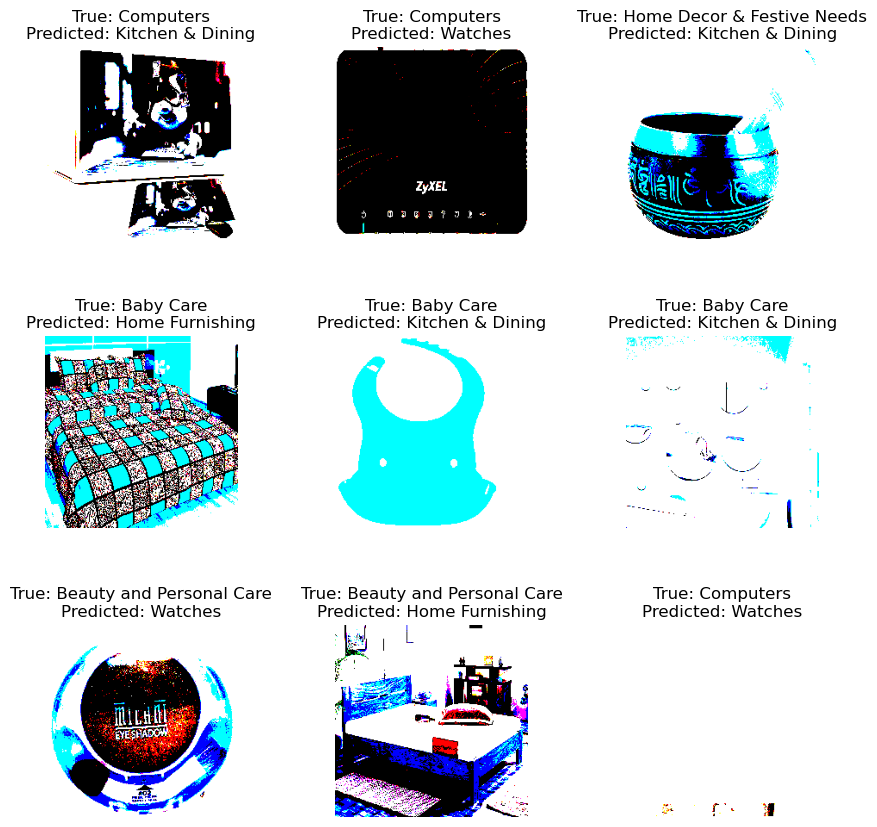

In [150]:
num_rows = 3
num_cols = 3

# Create a new figure and set its size
plt.figure(figsize=(10, 10))

# Loop through the sampled indices and display the images in a grid
for i, index in enumerate(sample_indices):
    true_categ = mapping.loc[mapping['label'] == y_test_num[index], 'cat1'].values[0]
    pred_categ = mapping.loc[mapping['label'] == y_test_pred[index], 'cat1'].values[0]

    # Display the corresponding image in the subplot grid
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[index])
    plt.axis('off')
    plt.title(f'True: {true_categ}\nPredicted: {pred_categ}')

# Adjust layout
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Show the grid of images
plt.show()

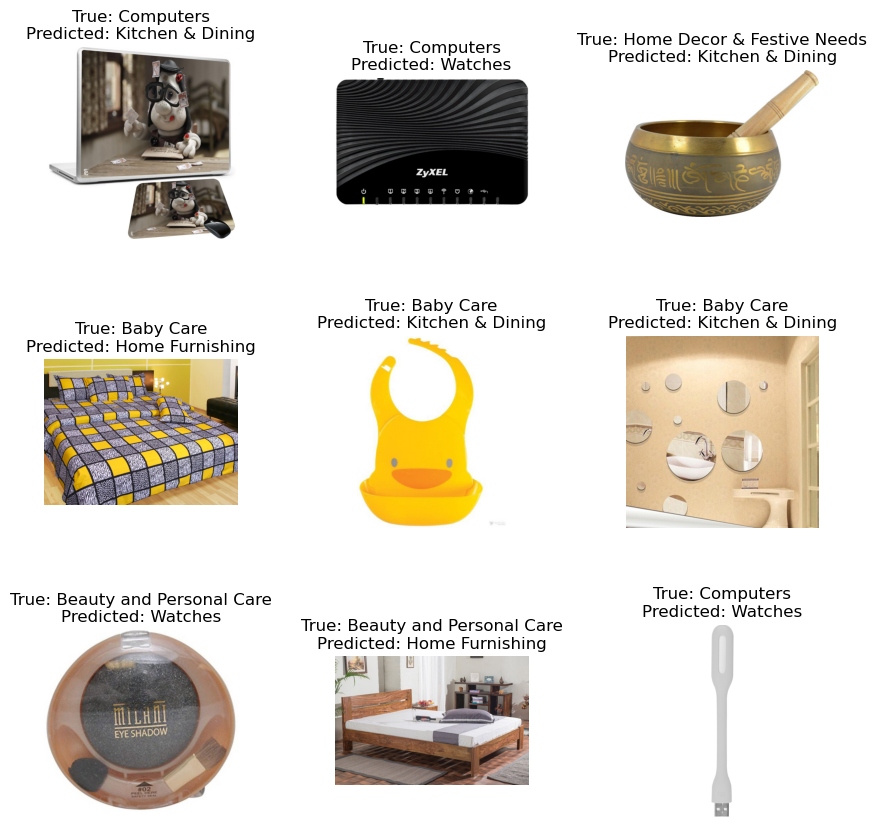

In [151]:
num_rows = 3
num_cols = 3

# Create a new figure and set its size
plt.figure(figsize=(10, 10))

# Loop through the sampled indices and display the images in a grid
for i, index in enumerate(sample_indices):
    true_categ = mapping.loc[mapping['label'] == y_test_num[index], 'cat1'].values[0]
    pred_categ = mapping.loc[mapping['label'] == y_test_pred[index], 'cat1'].values[0]

    # Display the corresponding image in the subplot grid
    plt.subplot(num_rows, num_cols, i + 1)
    img_path = data_test['image_path'].iloc[index]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {true_categ}\nPredicted: {pred_categ}')

# Adjust layout
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Show the grid of images
plt.show()

In [152]:
# Sample 
sample_indices = np.random.choice(incorrect_indices, size=min(9, len(incorrect_indices)), replace=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


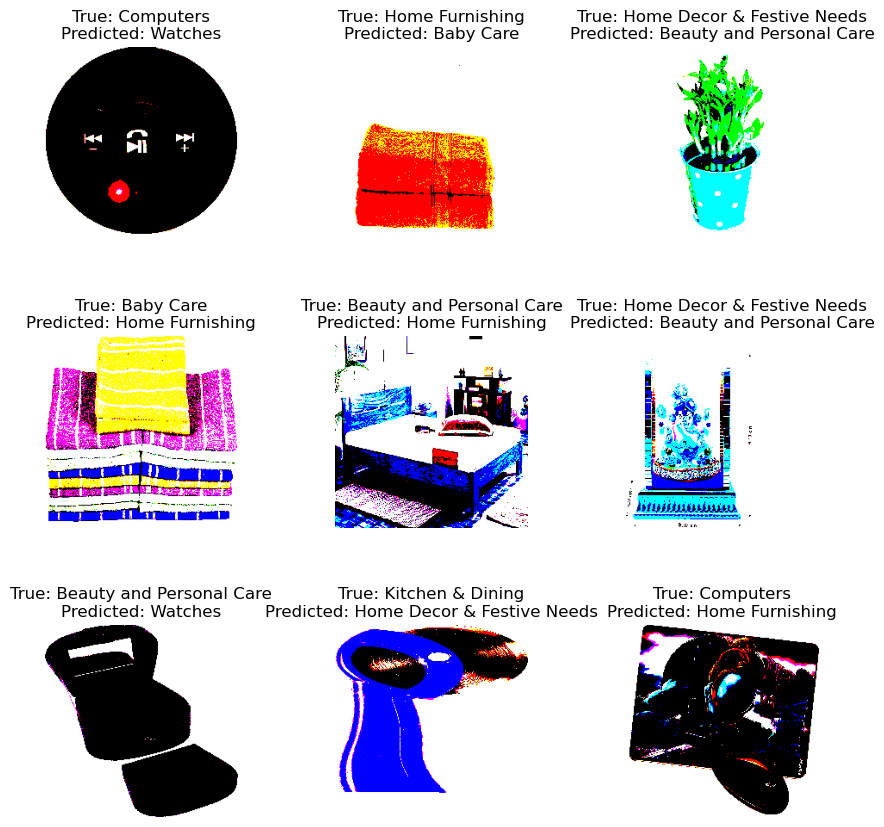

In [153]:
num_rows = 3
num_cols = 3

# Create a new figure and set its size
plt.figure(figsize=(10, 10))

# Loop through the sampled indices and display the images in a grid
for i, index in enumerate(sample_indices):
    true_categ = mapping.loc[mapping['label'] == y_test_num[index], 'cat1'].values[0]
    pred_categ = mapping.loc[mapping['label'] == y_test_pred[index], 'cat1'].values[0]

    # Display the corresponding image in the subplot grid
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[index])
    plt.axis('off')
    plt.title(f'True: {true_categ}\nPredicted: {pred_categ}')

# Adjust layout
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Show the grid of images
plt.show()

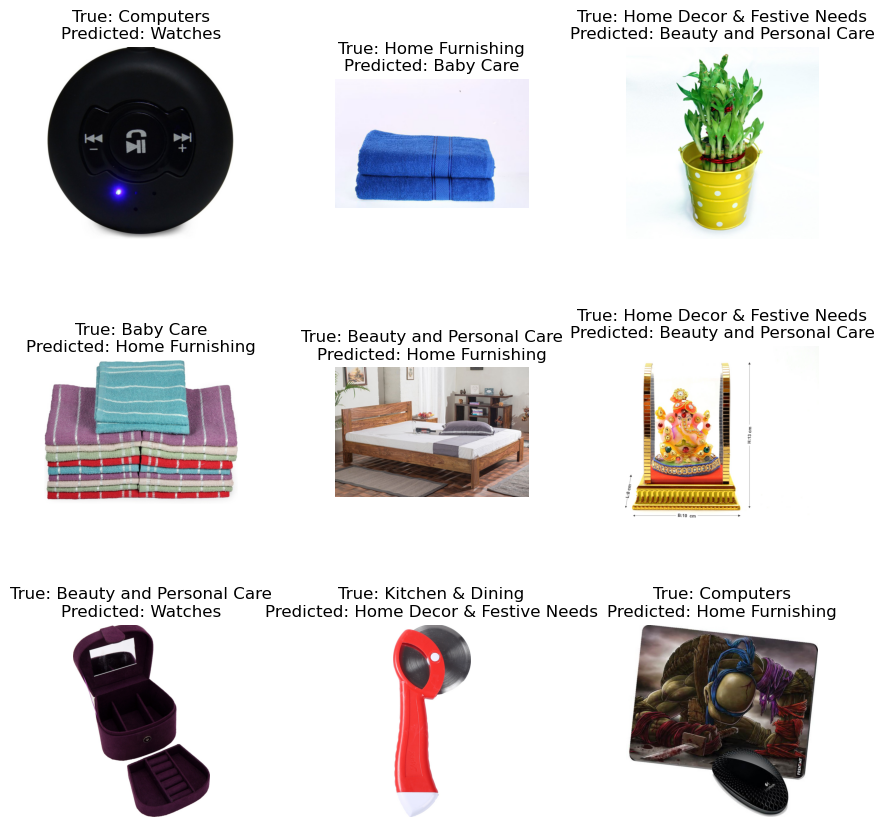

In [154]:
num_rows = 3
num_cols = 3

# Create a new figure and set its size
plt.figure(figsize=(10, 10))

# Loop through the sampled indices and display the images in a grid
for i, index in enumerate(sample_indices):
    true_categ = mapping.loc[mapping['label'] == y_test_num[index], 'cat1'].values[0]
    pred_categ = mapping.loc[mapping['label'] == y_test_pred[index], 'cat1'].values[0]

    # Display the corresponding image in the subplot grid
    plt.subplot(num_rows, num_cols, i + 1)
    img_path = data_test['image_path'].iloc[index]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {true_categ}\nPredicted: {pred_categ}')

# Adjust layout
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Show the grid of images
plt.show()

#### Conclusions
Images mal classées de base.  
Motifs identifiés à l'objet.  
Objets de forme similaire.  
Objets avec un fond vs objets détourés.  
Catégories qui se recoupent : même un humain n'aurait pas su.

Essayons d'améliorer ce modèle avec de la data augmentation

## 3.2 VGG16, pre trained, with data augmentation

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
data_train

,uniq_id,image_path,cat1,label
799,5188dd28a627807407d93549580afb74,Images/5188dd28a627807407d93549580afb74.jpg,Home Furnishing,4
324,a43fbae655e5d13215b9dd65339fa9d4,Images/a43fbae655e5d13215b9dd65339fa9d4.jpg,Computers,2
173,6b043b37c38f081d96886acb5acfbdf5,Images/6b043b37c38f081d96886acb5acfbdf5.jpg,Kitchen & Dining,5
391,7fd12776e6d62da6e1dd3cbc9882ee5f,Images/7fd12776e6d62da6e1dd3cbc9882ee5f.jpg,Computers,2
670,d06bb04b096c77dc3302eaf2db336f96,Images/d06bb04b096c77dc3302eaf2db336f96.jpg,Baby Care,0
...,...,...,...,...
228,9f76aaed44b540869da862c5dd4b266f,Images/9f76aaed44b540869da862c5dd4b266f.jpg,Home Decor & Festive Needs,3
924,a618354ba17cff64826558d81afc77ab,Images/a618354ba17cff64826558d81afc77ab.jpg,Beauty and Personal Care,1
95,f4d4c2eec77732f56e47722d7a355f2b,Images/f4d4c2eec77732f56e47722d7a355f2b.jpg,Home Decor & Festive Needs,3
800,93f45475c82bdee6df73c6e08011b7da,Images/93f45475c82bdee6df73c6e08011b7da.jpg,Computers,2


In [56]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='cat1',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [57]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)


Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [58]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5.keras"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [59]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [60]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 6/20 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.2215 - loss: 9.7738 

C:\Users\LENOVO\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3340 - loss: 6.8734
Epoch 1: val_loss improved from inf to 1.43053, saving model to ./model2_best_weights.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.3397 - loss: 6.7639 - val_accuracy: 0.7286 - val_loss: 1.4305
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6640 - loss: 1.6878
Epoch 2: val_loss improved from 1.43053 to 1.22514, saving model to ./model2_best_weights.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.6637 - loss: 1.6887 - val_accuracy: 0.7810 - val_loss: 1.2251
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7499 - loss: 0.9828
Epoch 3: val_loss improved from 1.22514 to 1.20832, saving model to ./model2_best_weights.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.7489 - loss: 0.9951 - val_accuracy: 0.7619 - val_loss: 1.2083
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8245 - loss: 0.7994
Epoch 4: val_loss improved from 1.20832 t

In [62]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9730 - loss: 0.0964
Training Accuracy   : 0.9746

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7509 - loss: 1.1634
Validation Accuracy :  0.7619


In [63]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7857
Test Accuracy       :  0.7857


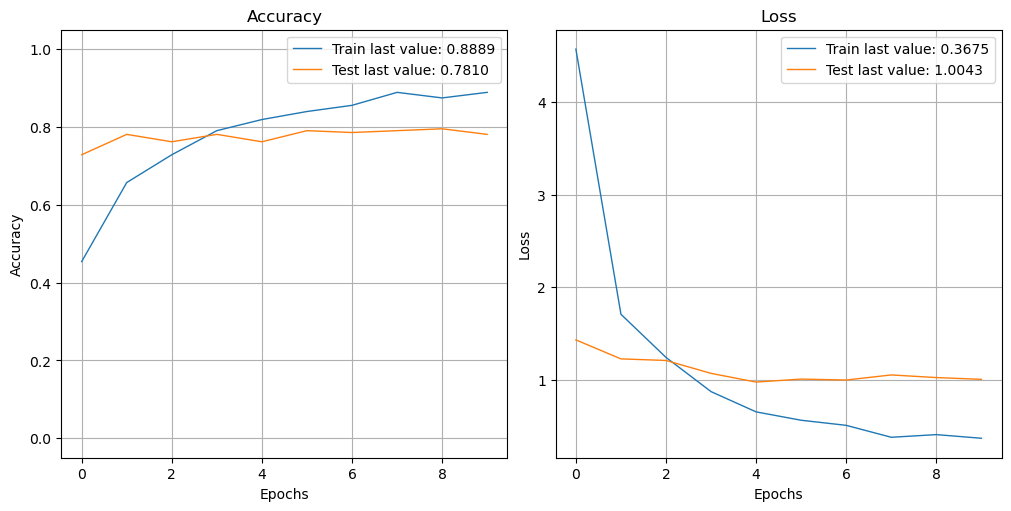

In [64]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

Le modèle est aussi performant : logique ?

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

### Training

In [155]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [156]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [157]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5.keras"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [158]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [159]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0990 - loss: 14.2202
Epoch 1: val_loss improved from inf to 4.84178, saving model to ./model3_best_weights.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.0993 - loss: 14.1063 - val_accuracy: 0.1238 - val_loss: 4.8418
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1521 - loss: 6.0521
Epoch 2: val_loss improved from 4.84178 to 3.16505, saving model to ./model3_best_weights.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.1520 - loss: 6.0286 - val_accuracy: 0.1286 - val_loss: 3.1651
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1689 - loss: 3.8136
Epoch 3: val_loss improved from 3.16505 to 2.43019, saving model to ./model3_best_weights.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.1678 - loss: 3.7999 - val_accuracy: 0.1762 - val_loss: 2.4302
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1297 - loss: 2.6504
Epoch 4: val_loss improved f

KeyboardInterrupt: 

In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

In [ ]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()